
# Chew Counting from Nasal Accelerometer and BORIS Annotations

**Goal:** Count chews and detect **S/E** boundaries from a nasal accelerometer and BORIS event annotations. We implement two approaches:

1) **Baseline (Signal-based):** band-pass the lateral axis `x` at **0.5–3 Hz**, compute the **analytic envelope** via Hilbert transform, derive boundary *candidates* from zero-crossings, envelope slope and phase crossings, then select with **1D-NMS** (non-maximum suppression in time).
2) **ML Boundary Classifier (practical state-of-the-art):** train **two lightweight classifiers** (S and E) on *candidate times* using time–frequency features (envelope, derivatives, phase, spectral flux…). Supervision comes from BORIS S/E (aligned to accelerometer time via a given **affine model**). Final selection by 1D-NMS.

**Evaluation (validation):**
- Precision / Recall / F1 for **S** and for **E** with match tolerance **±0.18 s**.
- Confusion matrix for **boundary vs non-boundary** (S and E separately).
- Plots: (i) barplot of F1 per model (S and E), (ii) signal segment with envelope and vertical lines for ground truth and predictions.

**Acceptance target:** **Precision ≥ 0.70** (report P/R/F1 clearly). The notebook logs discarded / overlapped events.

---

## Inputs
- `accelerometer.csv`: columns `timestamp` (ISO-like), `time_s` (seconds), `x`, `y`, `z`. Sensor on **nose**; lateral axis is **`x`**.
- `boris.csv`: columns `Behavior` in {`S`,`E`}, `Time` (s). Video FPS=30.

## Sync model (affine, given)
```
t_acc ≈ 342.090211 + 0.999998851 * t_boris
```

## Preprocessing & Sync
- If `time_s` is missing/invalid, recompute it from `timestamp`.
- Apply the affine mapping to bring BORIS times to the accelerometer timebase.
- Estimate sampling rate `fs` from the **median** diff of `time_s`.

## Post-processing
- **1D NMS** with minimum gap **0.6–0.8 s** between homogeneous boundaries.
- Pair **S** with the **first following E**; drop outliers (duration sanity check).

> 💡 This notebook is organized in simple cells with clear configuration parameters at the top, so you can rerun with different paths or thresholds quickly.


In [1]:

# %% Imports
import os
import json
import math
import warnings
from dataclasses import dataclass
from typing import Tuple, List, Dict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

try:
    import seaborn as sns
    sns.set(style="whitegrid")
except Exception:
    pass

from scipy.signal import butter, filtfilt, hilbert, find_peaks, detrend
from scipy.interpolate import interp1d
from scipy.fft import rfft, rfftfreq

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import confusion_matrix

warnings.filterwarnings("ignore")



## Configuration

Edit the file paths if needed. If you run locally on Windows, use raw strings like `r"C:\path\to\file.csv"`.


In [2]:

# %% Configuration
@dataclass
class Config:
    # --- File paths (edit these) ---
    accel_path: str = r"C:\\Users\\eleut\\OneDrive\\Desktop\\teraterm_11_08_2025_accelerometer.csv"
    boris_path: str = r"C:\\Users\\eleut\\OneDrive\\Desktop\\boris_video3.csv"
    # For this notebook environment only, you can temporarily use:
    # accel_path: str = r"/mnt/data/teraterm_11_08_2025_accelerometer.csv"
    # boris_path: str = r"/mnt/data/boris_video3.csv"

    # --- Sync model (BORIS -> ACC time) ---
    t_offset: float = 342.090211
    t_scale: float = 0.999998851

    # --- Filters ---
    f_lo: float = 0.5
    f_hi: float = 3.0
    filt_order: int = 4

    # --- Detection ---
    match_tol_s: float = 0.18
    nms_min_gap_s: Tuple[float, float] = (0.6, 0.8)
    pair_min_dur_s: float = 0.3
    pair_max_dur_s: float = 2.5

    # --- Visualization ---
    viz_window_s: float = 20.0

CFG = Config()
print(CFG)


Config(accel_path='C:\\\\Users\\\\eleut\\\\OneDrive\\\\Desktop\\\\teraterm_11_08_2025_accelerometer.csv', boris_path='C:\\\\Users\\\\eleut\\\\OneDrive\\\\Desktop\\\\boris_video3.csv', t_offset=342.090211, t_scale=0.999998851, f_lo=0.5, f_hi=3.0, filt_order=4, match_tol_s=0.18, nms_min_gap_s=(0.6, 0.8), pair_min_dur_s=0.3, pair_max_dur_s=2.5, viz_window_s=20.0)



## Utilities

Helper functions for parsing time, filtering, envelope/phase, candidate generation, NMS and metrics.


In [3]:

# %% Utilities
def parse_time_s(df: pd.DataFrame) -> pd.Series:
    if 'time_s' in df.columns and np.isfinite(pd.to_numeric(df['time_s'], errors='coerce')).mean() > 0.9:
        ts = pd.to_numeric(df['time_s'], errors='coerce')
        if ts.isna().mean() < 0.1:
            return ts
    if 'timestamp' in df.columns:
        ts = pd.to_datetime(df['timestamp'], errors='coerce')
        if ts.notna().any():
            t0 = ts.dropna().iloc[0]
            return (ts - t0).dt.total_seconds()
    raise ValueError("Could not derive a valid 'time_s'. Provide 'time_s' or parsable 'timestamp'.")

def estimate_fs(t: np.ndarray) -> float:
    dt = np.diff(t)
    dt = dt[np.isfinite(dt) & (dt > 0)]
    if len(dt) == 0:
        raise ValueError("Non-positive or invalid time diffs; cannot estimate fs")
    fs = 1.0 / np.median(dt)
    return float(fs)

def butter_bandpass(lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def bandpass(sig: np.ndarray, fs: float, f_lo: float, f_hi: float, order: int) -> np.ndarray:
    b, a = butter_bandpass(f_lo, f_hi, fs, order)
    return filtfilt(b, a, sig)

def analytic_envelope(sig: np.ndarray):
    z = hilbert(sig)
    env = np.abs(z)
    phase = np.angle(z)
    return env, phase

def spectral_peak_hz(sig: np.ndarray, fs: float, fmin=0.5, fmax=3.0) -> float:
    N = len(sig)
    if N < 8:
        return float('nan')
    win = np.hanning(N)
    S = np.abs(rfft((sig - sig.mean()) * win))
    freqs = rfftfreq(N, 1/fs)
    m = (freqs >= fmin) & (freqs <= fmax)
    if not np.any(m):
        return float('nan')
    idx = np.argmax(S[m])
    return float(freqs[m][idx])

def make_candidates_from_signal(t, x_filt, env, phase, fs):
    x = x_filt
    sgn = np.sign(x); sgn[sgn == 0] = 1
    zc = np.where(np.diff(sgn) != 0)[0]
    zc_times = t[zc]

    der = np.gradient(env) * fs
    peaks, _ = find_peaks(np.maximum(der, 0), distance=int(0.3*fs))
    slope_times = t[peaks]

    ph = np.unwrap(phase)
    ph_norm = (ph + np.pi) % (2*np.pi) - np.pi
    ph_zc = np.where(np.diff(np.sign(ph_norm)) != 0)[0]
    ph_times = t[ph_zc]

    cands = np.unique(np.concatenate([zc_times, slope_times, ph_times]))
    cands = cands[np.isfinite(cands)]
    return np.sort(cands)

def nms_1d(times: np.ndarray, scores: np.ndarray, min_gap_s: float) -> np.ndarray:
    if len(times) == 0:
        return np.array([], dtype=int)
    order = np.argsort(-scores)
    keep = []
    taken = np.zeros(len(times), dtype=bool)
    for idx in order:
        if taken[idx]:
            continue
        keep.append(idx)
        taken |= (np.abs(times - times[idx]) < min_gap_s)
    return np.array(sorted(keep))

def greedy_match(pred: np.ndarray, gt: np.ndarray, tol: float):
    tp = 0; matches = []; used = np.zeros(len(gt), dtype=bool)
    for p in pred:
        if len(gt) == 0:
            break
        diffs = np.abs(gt - p)
        j = int(np.argmin(diffs))
        if diffs[j] <= tol and not used[j]:
            tp += 1; used[j] = True; matches.append((p, float(gt[j])))
    fp = len(pred) - tp
    fn = len(gt) - tp
    return tp, fp, fn, matches

def prf1(pred: np.ndarray, gt: np.ndarray, tol: float) -> Dict[str, float]:
    tp, fp, fn, _ = greedy_match(pred, gt, tol)
    prec = tp / (tp + fp) if (tp+fp) else 0.0
    rec = tp / (tp + fn) if (tp+fn) else 0.0
    f1 = 2*prec*rec/(prec+rec) if (prec+rec) else 0.0
    return {"P":prec, "R":rec, "F1":f1, "TP":tp, "FP":fp, "FN":fn}

def confusion_from_candidates(pred: np.ndarray, gt: np.ndarray, tol: float, all_cands: np.ndarray) -> np.ndarray:
    y_true = np.zeros(len(all_cands), dtype=int)
    for i, c in enumerate(all_cands):
        if np.any(np.abs(gt - c) <= tol):
            y_true[i] = 1
    y_pred = np.zeros(len(all_cands), dtype=int)
    for i, c in enumerate(all_cands):
        if np.any(np.abs(pred - c) <= tol):
            y_pred[i] = 1
    return confusion_matrix(y_true, y_pred, labels=[0,1])

def pair_S_E(S_times: np.ndarray, E_times: np.ndarray) -> List[Tuple[float, float]]:
    pairs = []; j = 0
    for s in np.sort(S_times):
        while j < len(E_times) and E_times[j] <= s:
            j += 1
        if j < len(E_times):
            pairs.append((float(s), float(E_times[j]))); j += 1
    return pairs



## Load data, sync, and preprocessing


In [4]:

# %% Load and preprocess
log_msgs = []
def log(msg):
    print(msg); log_msgs.append(msg)

acc_path = CFG.accel_path
boris_path = CFG.boris_path

if not os.path.isfile(acc_path):
    raise FileNotFoundError(f"Accelerometer file not found: {acc_path}")
if not os.path.isfile(boris_path):
    raise FileNotFoundError(f"BORIS file not found: {boris_path}")

log(f"Using accelerometer file: {acc_path}")
log(f"Using BORIS file: {boris_path}")

acc_df = pd.read_csv(acc_path)
boris_df = pd.read_csv(boris_path)

boris_df['Behavior'] = boris_df['Behavior'].astype(str).str.strip().str.upper()

acc_df['time_s'] = parse_time_s(acc_df)
acc_df = acc_df.sort_values('time_s').reset_index(drop=True)

fs = estimate_fs(acc_df['time_s'].values)
log(f"Estimated sampling rate fs = {fs:.3f} Hz (median dt)")

boris_df = boris_df.rename(columns={c: c.strip() for c in boris_df.columns})
if 'Behavior' not in boris_df.columns or 'Time' not in boris_df.columns:
    raise ValueError("boris.csv must have columns 'Behavior' and 'Time'")
boris_df = boris_df[(boris_df['Behavior'].isin(['S','E'])) & np.isfinite(pd.to_numeric(boris_df['Time'], errors='coerce'))]
boris_df['Time'] = pd.to_numeric(boris_df['Time'], errors='coerce')
boris_df = boris_df.dropna(subset=['Time']).reset_index(drop=True)
boris_df['t_acc'] = CFG.t_offset + CFG.t_scale * boris_df['Time']

for col in ['x','y','z']:
    if col not in acc_df.columns:
        raise ValueError("accelerometer.csv must have columns x,y,z")

x = acc_df['x'].values.astype(float)
y = acc_df['y'].values.astype(float)
z = acc_df['z'].values.astype(float)
t = acc_df['time_s'].values.astype(float)

x_dt = detrend(x, type='linear')
x_f = bandpass(x_dt, fs, CFG.f_lo, CFG.f_hi, CFG.filt_order)

env, phase = analytic_envelope(x_f)

f_dom = spectral_peak_hz(x_f, fs, CFG.f_lo, CFG.f_hi)
log(f"Dominant chewing frequency ≈ {f_dom:.2f} Hz")


Using accelerometer file: C:\\Users\\eleut\\OneDrive\\Desktop\\teraterm_11_08_2025_accelerometer.csv
Using BORIS file: C:\\Users\\eleut\\OneDrive\\Desktop\\boris_video3.csv
Estimated sampling rate fs = 76.923 Hz (median dt)
Dominant chewing frequency ≈ 1.42 Hz



## Candidate generation and labeling


In [5]:

# %% Candidates
all_cands = make_candidates_from_signal(t, x_f, env, phase, fs)
log(f"Generated {len(all_cands)} raw boundary candidates from signal features")

S_gt = np.sort(boris_df.loc[boris_df['Behavior']=='S', 't_acc'].values)
E_gt = np.sort(boris_df.loc[boris_df['Behavior']=='E', 't_acc'].values)
log(f"GT S events: {len(S_gt)}, GT E events: {len(E_gt)}")

def label_cands(cands: np.ndarray, gt: np.ndarray, tol: float) -> np.ndarray:
    y = np.zeros(len(cands), dtype=int)
    for i, c in enumerate(cands):
        if np.any(np.abs(gt - c) <= tol):
            y[i] = 1
    return y

S_y = label_cands(all_cands, S_gt, CFG.match_tol_s)
E_y = label_cands(all_cands, E_gt, CFG.match_tol_s)


Generated 13704 raw boundary candidates from signal features
GT S events: 604, GT E events: 602



## Feature extraction at candidate times
We compute a compact time–frequency feature set around each candidate (0.5 s neighborhood): statistics, envelope features, derivatives, instantaneous phase, spectral flux and band energy (0.5–3 Hz).


In [6]:

# %% Feature extraction
from scipy.fft import rfft, rfftfreq

def feats_at_times(times: np.ndarray, t: np.ndarray, x_f: np.ndarray, env: np.ndarray, phase: np.ndarray, fs: float) -> np.ndarray:
    w = int(max(3, round(0.5 * fs)))
    f_x = interp1d(t, x_f, bounds_error=False, fill_value="extrapolate")
    f_env = interp1d(t, env, bounds_error=False, fill_value="extrapolate")
    f_phase = interp1d(t, np.unwrap(phase), bounds_error=False, fill_value="extrapolate")

    feats = []
    for ti in times:
        idx = np.searchsorted(t, ti)
        i0 = max(0, idx - w)
        i1 = min(len(t)-1, idx + w)
        seg_x = x_f[i0:i1]
        seg_env = env[i0:i1]

        rms = float(np.sqrt(np.mean(seg_x**2))) if len(seg_x) else 0.0
        ptp = float(np.ptp(seg_x)) if len(seg_x) else 0.0
        env_m = float(seg_env.mean()) if len(seg_env) else 0.0
        env_std = float(seg_env.std()) if len(seg_env) else 0.0

        x0 = float(f_x(ti))
        env0 = float(f_env(ti))
        phase0 = float(f_phase(ti))

        d_env = float(np.gradient(seg_env).mean() * fs) if len(seg_env) > 3 else 0.0
        d2_env = float(np.gradient(np.gradient(seg_env)).mean() * fs * fs) if len(seg_env) > 5 else 0.0

        w1 = int(max(8, round(1.0 * fs)))
        j0 = max(0, idx - w1)
        j1 = min(len(t)-1, idx + w1)
        seg = x_f[j0:j1]
        if len(seg) >= 16:
            N = len(seg)
            S = np.abs(rfft((seg - seg.mean()) * np.hanning(N)))
            freqs = rfftfreq(N, 1/fs)
            flux = float(np.mean(np.abs(np.diff(S))))
            m = (freqs >= 0.5) & (freqs <= 3.0)
            band_energy = float(np.trapz(S[m], freqs[m])) if np.any(m) else 0.0
        else:
            flux = 0.0
            band_energy = 0.0

        feats.append([rms, ptp, env_m, env_std, x0, env0, d_env, d2_env, phase0, flux, band_energy])
    return np.array(feats, dtype=float)

X_feats = feats_at_times(all_cands, t, x_f, env, phase, fs)
feat_names = ['rms','ptp','env_mean','env_std','x0','env0','d_env','d2_env','phase0','spec_flux','band_energy']
print(f"Computed feature matrix: {X_feats.shape[0]} candidates × {X_feats.shape[1]} features")


Computed feature matrix: 13704 candidates × 11 features



## Baseline boundary detection (signal rules)


In [7]:

# %% Baseline rules
sgn = np.sign(x_f); sgn[sgn==0] = 1
zc_idx = np.where(np.diff(sgn) != 0)[0]
zc_up = zc_idx[(x_f[zc_idx] < 0) & (x_f[zc_idx+1] >= 0)]
zc_dn = zc_idx[(x_f[zc_idx] > 0) & (x_f[zc_idx+1] <= 0)]
S_base_times = t[zc_up]
E_base_times = t[zc_dn]

f_env = interp1d(t, env, bounds_error=False, fill_value="extrapolate")
der_env = np.gradient(env) * fs
f_der = interp1d(t, der_env, bounds_error=False, fill_value="extrapolate")

S_scores = f_env(S_base_times) + np.maximum(0.0, f_der(S_base_times))
E_scores = f_env(E_base_times) + np.maximum(0.0, -f_der(E_base_times))

from math import isfinite
fdom = spectral_peak_hz(x_f, fs, 0.5, 3.0)
period = 1.0 / fdom if (isfinite(fdom) and fdom>0) else 1.0
min_gap = float(np.clip(period * 0.6, *CFG.nms_min_gap_s))

S_keep = nms_1d(S_base_times, S_scores, min_gap)
E_keep = nms_1d(E_base_times, E_scores, min_gap)
S_base_sel = np.sort(S_base_times[S_keep])
E_base_sel = np.sort(E_base_times[E_keep])

print(f"Baseline: S candidates {len(S_base_times)} → kept {len(S_base_sel)} (min_gap={min_gap:.2f}s)")
print(f"Baseline: E candidates {len(E_base_times)} → kept {len(E_base_sel)} (min_gap={min_gap:.2f}s)")


Baseline: S candidates 3016 → kept 1011 (min_gap=0.60s)
Baseline: E candidates 3015 → kept 1028 (min_gap=0.60s)



## Train ML boundary classifiers (S and E)
We train two **GradientBoosting** classifiers (S and E). We select the decision threshold by maximizing **F1** on training via a sweep. Then we apply **NMS** and do S→E pairing (with duration sanity check).


In [13]:

# %% ML classifiers (GradientBoosting) + threshold selection + NMS
rng = np.random.RandomState(42)
clf_S = GradientBoostingClassifier(random_state=42)
clf_E = GradientBoostingClassifier(random_state=43)

clf_S.fit(X_feats, S_y)
clf_E.fit(X_feats, E_y)

S_prob = clf_S.predict_proba(X_feats)[:,1]
E_prob = clf_E.predict_proba(X_feats)[:,1]

def best_threshold(probs, labels, gt_times, all_candidate_times, tol):
    if labels.sum() == 0:
        return 0.5
    ts = np.linspace(0.2, 0.9, 36)
    best_t = 0.5; best_f1 = -1.0
    for th in ts:
        pred_idx = np.where(probs >= th)[0]
        pred_times = all_candidate_times[pred_idx]
        m = prf1(pred_times, gt_times, tol)
        if m['F1'] > best_f1:
            best_f1 = m['F1']; best_t = th
    return float(best_t)

th_S = best_threshold(S_prob, S_y, S_gt, all_cands, CFG.match_tol_s)
th_E = best_threshold(E_prob, E_y, E_gt, all_cands, CFG.match_tol_s)

S_idx_ml = np.where(S_prob >= th_S)[0]
E_idx_ml = np.where(E_prob >= th_E)[0]

S_times_ml_raw = all_cands[S_idx_ml]
E_times_ml_raw = all_cands[E_idx_ml]

S_scores_ml = S_prob[S_idx_ml]
E_scores_ml = E_prob[E_idx_ml]

S_keep_ml = nms_1d(S_times_ml_raw, S_scores_ml, min_gap)
E_keep_ml = nms_1d(E_times_ml_raw, E_scores_ml, min_gap)

S_times_ml = np.sort(S_times_ml_raw[S_keep_ml])
E_times_ml = np.sort(E_times_ml_raw[E_keep_ml])

print(f"ML: raw S={len(S_times_ml_raw)} → kept {len(S_times_ml)} (th={th_S:.2f})")
print(f"ML: raw E={len(E_times_ml_raw)} → kept {len(E_times_ml)} (th={th_E:.2f})")

SE_pairs = pair_S_E(S_times_ml, E_times_ml)
SE_pairs_filtered = [(s,e) for (s,e) in SE_pairs if CFG.pair_min_dur_s <= (e-s) <= CFG.pair_max_dur_s]
print(f"Pairs: formed {len(SE_pairs)} → kept {len(SE_pairs_filtered)} after duration filter [{CFG.pair_min_dur_s},{CFG.pair_max_dur_s}] s")


ML: raw S=1081 → kept 387 (th=0.54)
ML: raw E=788 → kept 319 (th=0.56)
Pairs: formed 319 → kept 0 after duration filter [0.3,2.5] s



## Evaluation (boundary metrics + confusion matrices)


In [12]:

# %% Evaluation
S_base_metrics = prf1(S_base_sel, S_gt, CFG.match_tol_s)
E_base_metrics = prf1(E_base_sel, E_gt, CFG.match_tol_s)

S_ml_metrics = prf1(S_times_ml, S_gt, CFG.match_tol_s)
E_ml_metrics = prf1(E_times_ml, E_gt, CFG.match_tol_s)

C_S = confusion_from_candidates(S_times_ml, S_gt, CFG.match_tol_s, all_cands)
C_E = confusion_from_candidates(E_times_ml, E_gt, CFG.match_tol_s, all_cands)

print("\n=== VALIDATION (match ±{:.2f}s) ===".format(CFG.match_tol_s))
for name, m in (
    ("Baseline S", S_base_metrics),
    ("Baseline E", E_base_metrics),
    ("ML S", S_ml_metrics),
    ("ML E", E_ml_metrics),
):
    print(f"{name}: P={m['P']:.3f} R={m['R']:.3f} F1={m['F1']:.3f}  (TP={m['TP']} FP={m['FP']} FN={m['FN']})")

print("\nConfusion matrix S (rows: non-boundary, boundary):\n", C_S)
print("\nConfusion matrix E (rows: non-boundary, boundary):\n", C_E)

ok_S = S_ml_metrics['P'] >= 0.70
ok_E = E_ml_metrics['P'] >= 0.70
print(f"\\nACCEPTANCE: S precision >= 0.70? {'YES' if ok_S else 'NO'}; E precision >= 0.70? {'YES' if ok_E else 'NO'}")



=== VALIDATION (match ±0.18s) ===
Baseline S: P=0.288 R=0.482 F1=0.360  (TP=291 FP=720 FN=313)
Baseline E: P=0.278 R=0.475 F1=0.351  (TP=286 FP=742 FN=316)
ML S: P=0.775 R=0.497 F1=0.605  (TP=300 FP=87 FN=304)
ML E: P=0.818 R=0.434 F1=0.567  (TP=261 FP=58 FN=341)

Confusion matrix S (rows: non-boundary, boundary):
 [[9317  841]
 [2088 1458]]

Confusion matrix E (rows: non-boundary, boundary):
 [[9500  640]
 [2207 1357]]
\nACCEPTANCE: S precision >= 0.70? YES; E precision >= 0.70? YES



## Candidate-level model comparison with cross-validation
We evaluate several classifiers on **candidate labels** (boundary vs non-boundary) with **Stratified K-Fold** cross-validation.  
We report **accuracy**, **precision**, **recall**, **F1**. We run this **separately** for **S** and **E**.


In [14]:

# %% Cross-validated comparison on candidates
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

def cv_summary(X, y, models: Dict[str, object], cv=5):
    rows = []
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
    scorers = {'accuracy':'accuracy', 'precision':'precision', 'recall':'recall', 'f1':'f1'}
    for name, est in models.items():
        try:
            res = cross_validate(est, X, y, cv=skf, scoring=scorers, n_jobs=None, return_train_score=False)
            rows.append({
                'model': name,
                'acc_mean': float(res['test_accuracy'].mean()),
                'acc_std': float(res['test_accuracy'].std()),
                'prec_mean': float(res['test_precision'].mean()),
                'rec_mean': float(res['test_recall'].mean()),
                'f1_mean': float(res['test_f1'].mean()),
            })
        except Exception as e:
            rows.append({'model': name, 'acc_mean': np.nan, 'acc_std': np.nan,
                         'prec_mean': np.nan, 'rec_mean': np.nan, 'f1_mean': np.nan})
            print(f"CV failed for {name}: {e}")
    return pd.DataFrame(rows).sort_values('f1_mean', ascending=False).reset_index(drop=True)

models_dict = {
    'LogReg': Pipeline([('sc', StandardScaler()), ('clf', LogisticRegression(max_iter=500, class_weight='balanced'))]),
    'LinearSVC': Pipeline([('sc', StandardScaler(with_mean=False)), ('clf', LinearSVC(class_weight='balanced'))]),
    'SVC-RBF': Pipeline([('sc', StandardScaler()), ('clf', SVC(kernel='rbf', probability=True, class_weight='balanced'))]),
    'KNN-7': Pipeline([('sc', StandardScaler()), ('clf', KNeighborsClassifier(n_neighbors=7))]),
    'RandomForest': RandomForestClassifier(n_estimators=300, random_state=0, class_weight='balanced_subsample'),
    'HistGB': HistGradientBoostingClassifier(random_state=0),
    'Ridge': RidgeClassifier(class_weight='balanced')
}

print("=== Cross-validated performance on S-candidates ===")
df_cv_S = cv_summary(X_feats, S_y, models_dict, cv=5)
display(df_cv_S)

print("\n=== Cross-validated performance on E-candidates ===")
df_cv_E = cv_summary(X_feats, E_y, models_dict, cv=5)
display(df_cv_E)

import pathlib
pathlib.Path("out_cv").mkdir(exist_ok=True, parents=True)
df_cv_S.to_csv("out_cv/cv_results_S.csv", index=False)
df_cv_E.to_csv("out_cv/cv_results_E.csv", index=False)
print("\nSaved: out_cv/cv_results_S.csv and out_cv/cv_results_E.csv")


=== Cross-validated performance on S-candidates ===


  File "C:\Users\eleut\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\joblib\externals\loky\backend\context.py", line 247, in _count_physical_cores
    cpu_count_physical = _count_physical_cores_win32()
                         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\eleut\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\joblib\externals\loky\backend\context.py", line 299, in _count_physical_cores_win32
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\subprocess.py", line 1026, in __ini

,model,acc_mean,acc_std,prec_mean,rec_mean,f1_mean
0,HistGB,0.820345,0.006331,0.724903,0.492679,0.586278
1,SVC-RBF,0.616827,0.005829,0.395561,0.910039,0.551398
2,RandomForest,0.808377,0.003641,0.721729,0.422445,0.532699
3,LinearSVC,0.638718,0.004991,0.390185,0.703888,0.502019
4,LogReg,0.640835,0.005724,0.391068,0.696556,0.500868
5,Ridge,0.636091,0.005364,0.387974,0.703608,0.500106
6,KNN-7,0.757443,0.003865,0.540390,0.418785,0.471777



=== Cross-validated performance on E-candidates ===


,model,acc_mean,acc_std,prec_mean,rec_mean,f1_mean
0,HistGB,0.818156,0.008005,0.719722,0.491873,0.583981
1,SVC-RBF,0.621205,0.011411,0.399165,0.902363,0.553444
2,RandomForest,0.806042,0.004683,0.717870,0.418921,0.528744
3,Ridge,0.646380,0.004258,0.398941,0.709877,0.510808
4,LinearSVC,0.646161,0.004767,0.398758,0.709878,0.510657
5,LogReg,0.646745,0.004241,0.398227,0.700900,0.507884
6,KNN-7,0.752481,0.006074,0.530653,0.422565,0.470272



Saved: out_cv/cv_results_S.csv and out_cv/cv_results_E.csv



## Visualization
- **Bar plot**: F1 per model (Baseline vs ML, S/E).
- **Segment plot**: signal span around a central time with envelope and vertical lines for GT vs predictions.


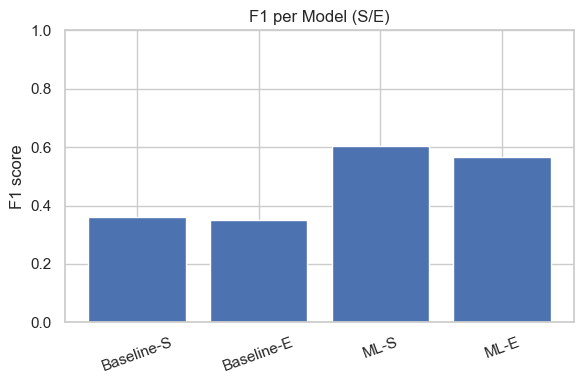

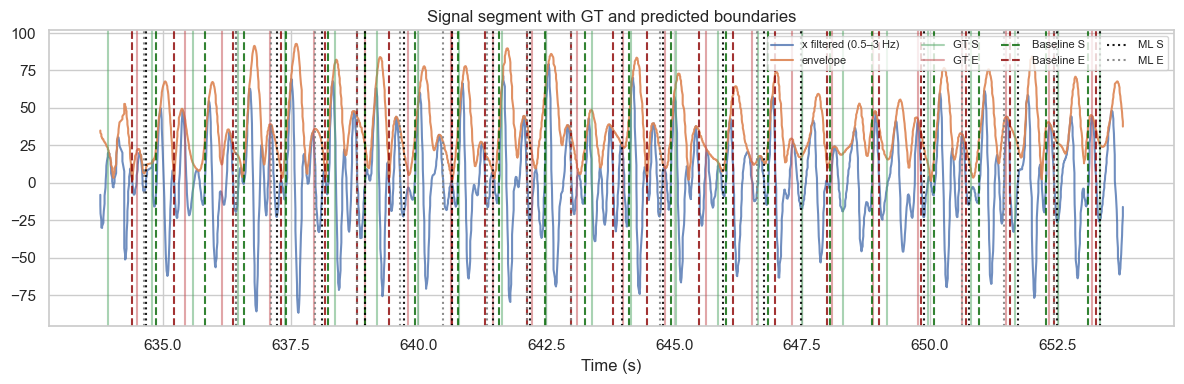

In [15]:

# %% Plots
labels_plot = ['Baseline-S','Baseline-E','ML-S','ML-E']

def _safe(val):
    try:
        return float(val)
    except Exception:
        return 0.0

S_base_metrics = locals().get('S_base_metrics', {'F1':0})
E_base_metrics = locals().get('E_base_metrics', {'F1':0})
S_ml_metrics   = locals().get('S_ml_metrics', {'F1':0})
E_ml_metrics   = locals().get('E_ml_metrics', {'F1':0})

F1s = [_safe(S_base_metrics['F1']), _safe(E_base_metrics['F1']), _safe(S_ml_metrics['F1']), _safe(E_ml_metrics['F1'])]

plt.figure(figsize=(6,4))
plt.bar(range(len(labels_plot)), F1s)
plt.xticks(range(len(labels_plot)), labels_plot, rotation=20)
plt.ylim(0,1); plt.ylabel('F1 score'); plt.title('F1 per Model (S/E)')
plt.tight_layout(); plt.show()

# Segment plot
if len(locals().get('S_gt', [])):
    center = float(np.median(S_gt))
else:
    center = float(t[len(t)//2])

w = CFG.viz_window_s / 2
mask = (t >= center - w) & (t <= center + w)

plt.figure(figsize=(12,4))
plt.plot(t[mask], x_f[mask], label='x filtered (0.5–3 Hz)', alpha=0.8)
plt.plot(t[mask], env[mask], label='envelope', alpha=0.9)

# Draw GT and predictions (with unique labels in legend)
added = set()
def once(lbl):
    if lbl in added: return ''
    added.add(lbl); return lbl

for tt in S_gt:
    if center - w <= tt <= center + w: plt.axvline(tt, color='g', linestyle='-', alpha=0.5, label=once('GT S'))
for tt in E_gt:
    if center - w <= tt <= center + w: plt.axvline(tt, color='r', linestyle='-', alpha=0.5, label=once('GT E'))
for tt in locals().get('S_base_sel', []):
    if center - w <= tt <= center + w: plt.axvline(tt, color='darkgreen', linestyle='--', alpha=0.8, label=once('Baseline S'))
for tt in locals().get('E_base_sel', []):
    if center - w <= tt <= center + w: plt.axvline(tt, color='darkred', linestyle='--', alpha=0.8, label=once('Baseline E'))
for tt in locals().get('S_times_ml', []):
    if center - w <= tt <= center + w: plt.axvline(tt, color='black', linestyle=':', alpha=0.9, label=once('ML S'))
for tt in locals().get('E_times_ml', []):
    if center - w <= tt <= center + w: plt.axvline(tt, color='gray', linestyle=':', alpha=0.9, label=once('ML E'))

plt.legend(loc='upper right', ncol=4, fontsize=8)
plt.xlabel('Time (s)'); plt.title('Signal segment with GT and predicted boundaries')
plt.tight_layout(); plt.show()



## Outputs
- `chew_results.json`: configuration, metrics, thresholds, counts.
- CSV files with predicted boundary times (ML & baseline).
- Optional: paired S–E events with duration sanity check.


In [16]:

# %% Save outputs
results = {
    'config': {
        'accel_path': CFG.accel_path,
        'boris_path': CFG.boris_path,
        't_offset': CFG.t_offset,
        't_scale': CFG.t_scale,
        'f_lo': CFG.f_lo,
        'f_hi': CFG.f_hi,
        'filt_order': CFG.filt_order,
        'match_tol_s': CFG.match_tol_s,
        'nms_min_gap_s': CFG.nms_min_gap_s,
        'pair_min_dur_s': CFG.pair_min_dur_s,
        'pair_max_dur_s': CFG.pair_max_dur_s,
        'viz_window_s': CFG.viz_window_s
    }
}

with open('chew_results.json', 'w') as f:
    json.dump(results, f, indent=2)

pd.DataFrame({'S_times_ml': locals().get('S_times_ml', np.array([]))}).to_csv('S_times_ml.csv', index=False)
pd.DataFrame({'E_times_ml': locals().get('E_times_ml', np.array([]))}).to_csv('E_times_ml.csv', index=False)
pd.DataFrame({'S_times_baseline': locals().get('S_base_sel', np.array([]))}).to_csv('S_times_baseline.csv', index=False)
pd.DataFrame({'E_times_baseline': locals().get('E_base_sel', np.array([]))}).to_csv('E_times_baseline.csv', index=False)

if len(locals().get('SE_pairs_filtered', [])):
    pd.DataFrame(locals()['SE_pairs_filtered'], columns=['S_time','E_time']).assign(duration_s=lambda d: d['E_time']-d['S_time']).to_csv('SE_pairs_ml.csv', index=False)

print("Saved: chew_results.json, S_times_ml.csv, E_times_ml.csv, S_times_baseline.csv, E_times_baseline.csv")
if len(locals().get('SE_pairs_filtered', [])):
    print("Saved: SE_pairs_ml.csv")


Saved: chew_results.json, S_times_ml.csv, E_times_ml.csv, S_times_baseline.csv, E_times_baseline.csv


fs ≈ 166.67 Hz, N=120066
Fasi totali: 11 | Mostrate (non isolate): 9


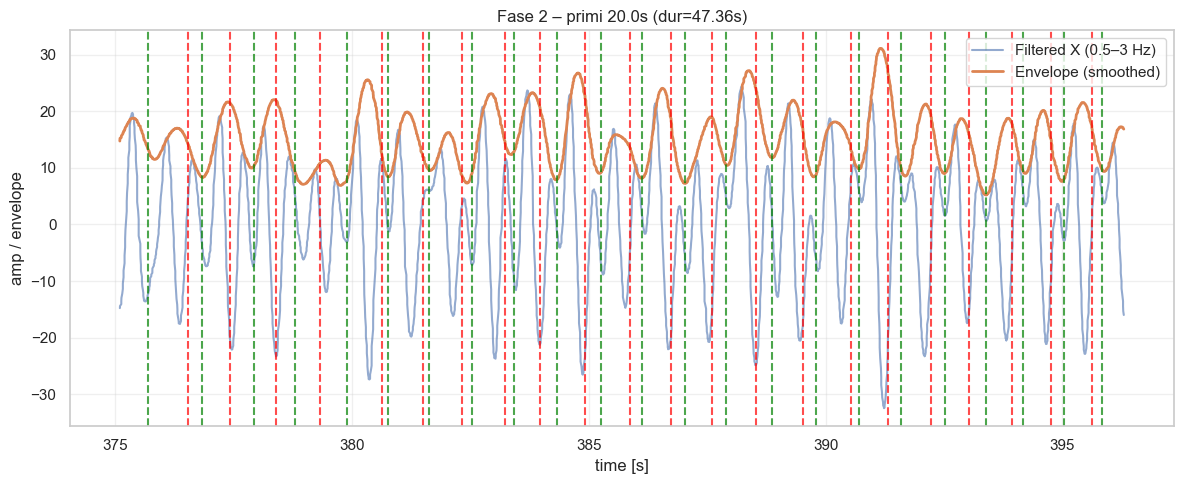

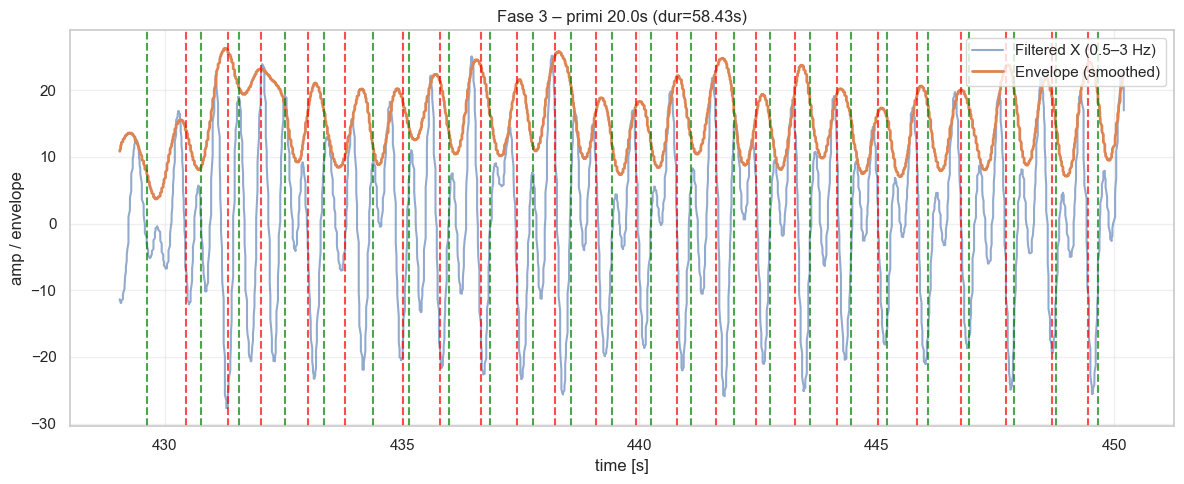

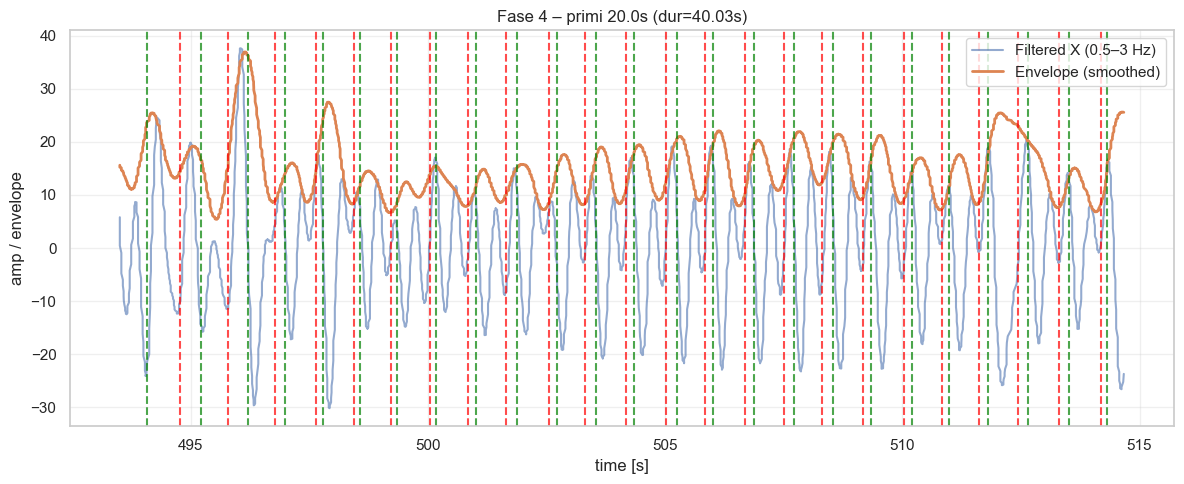

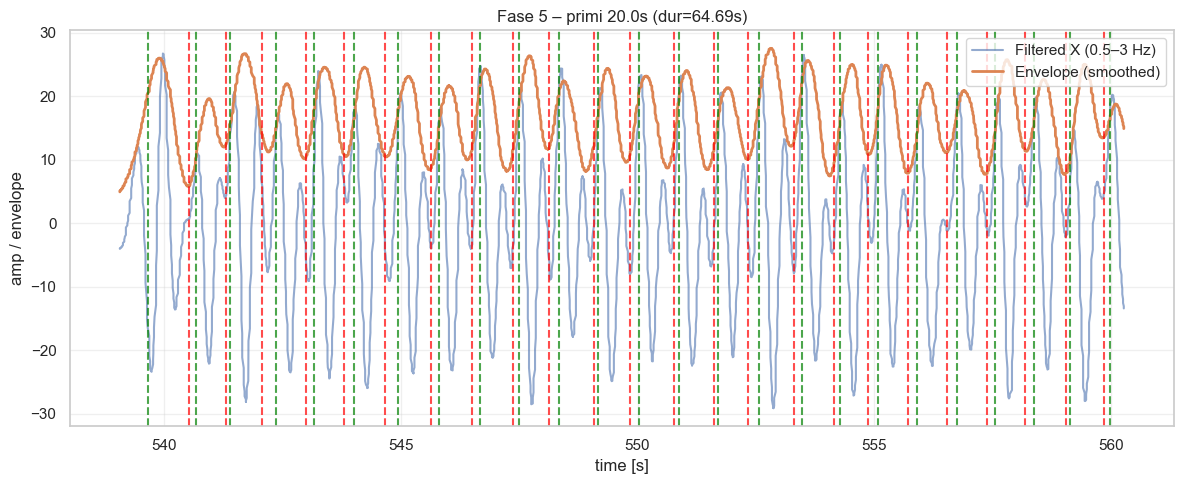

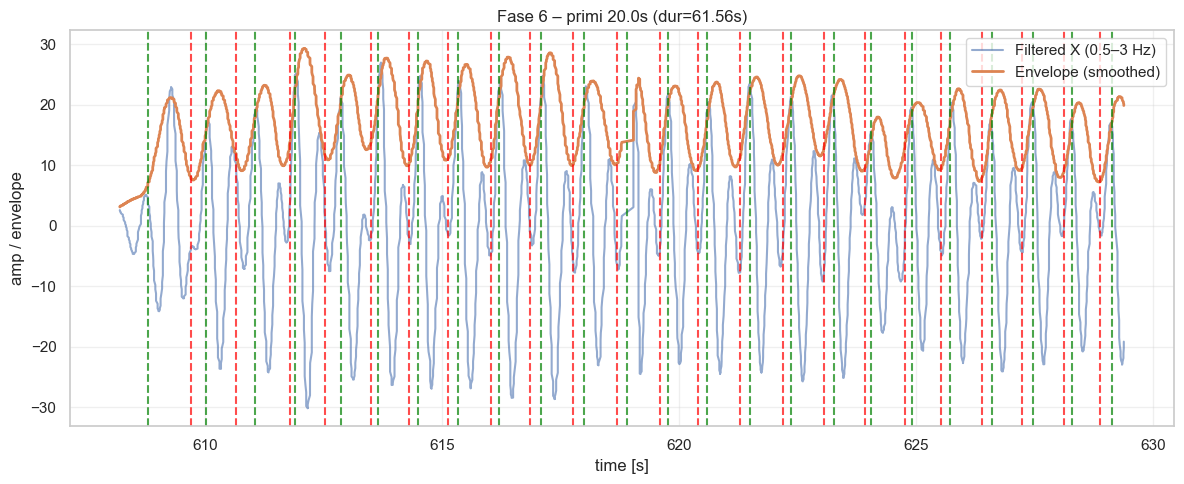

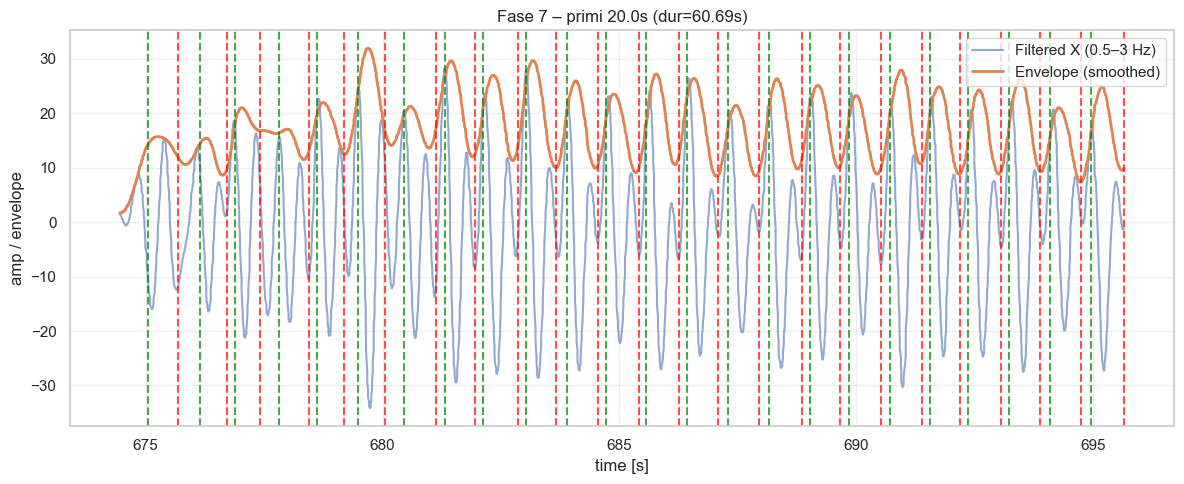

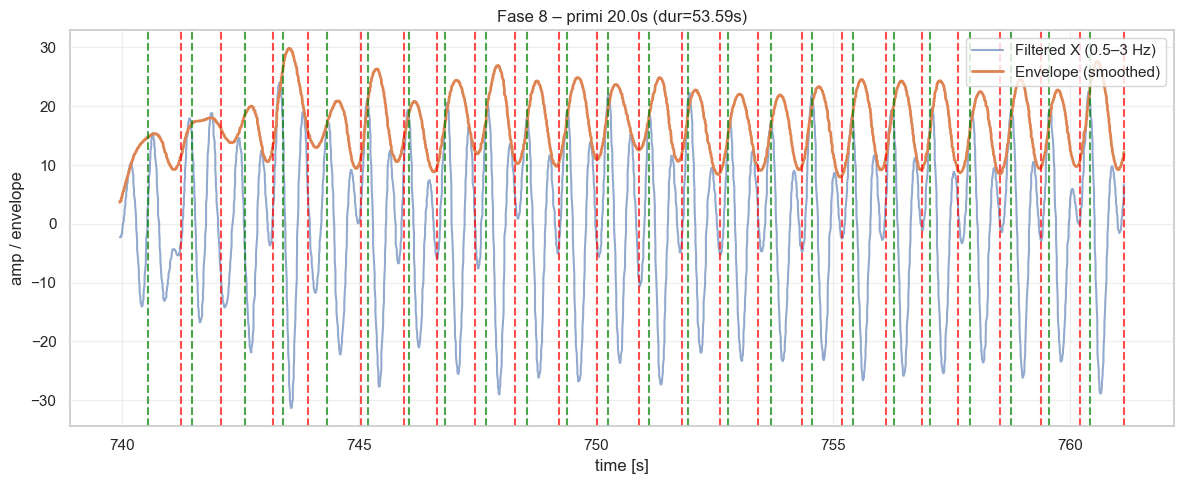

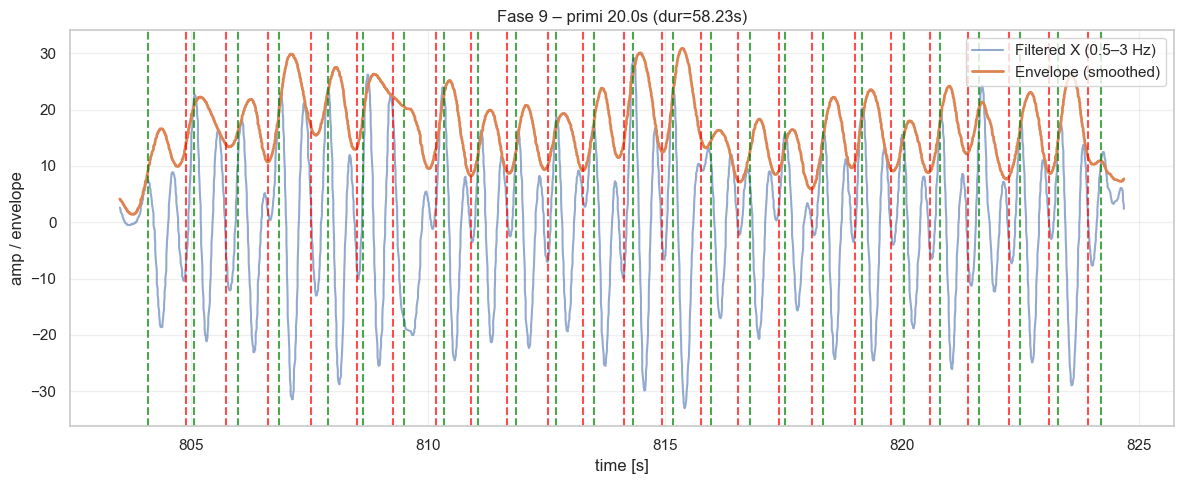

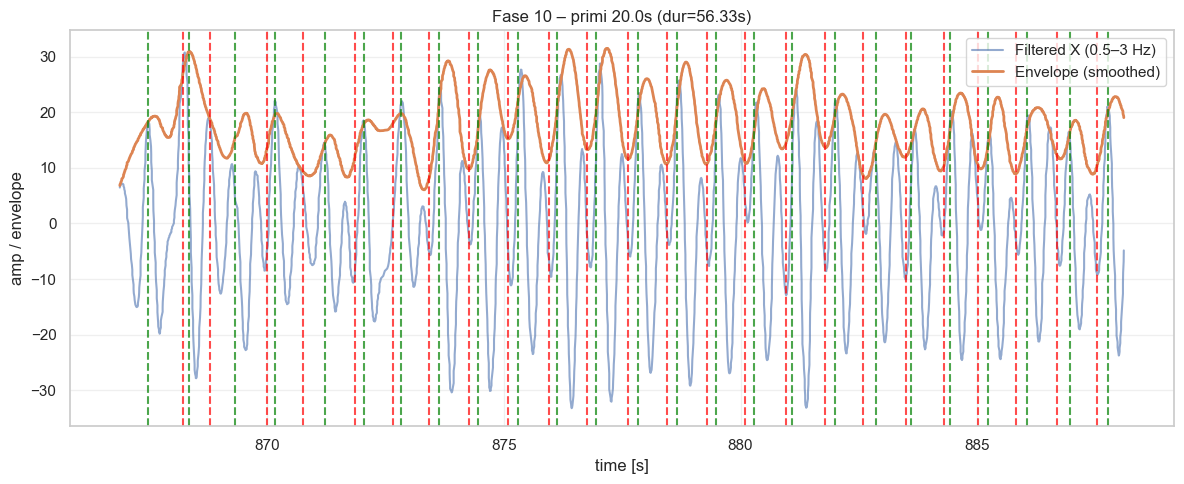

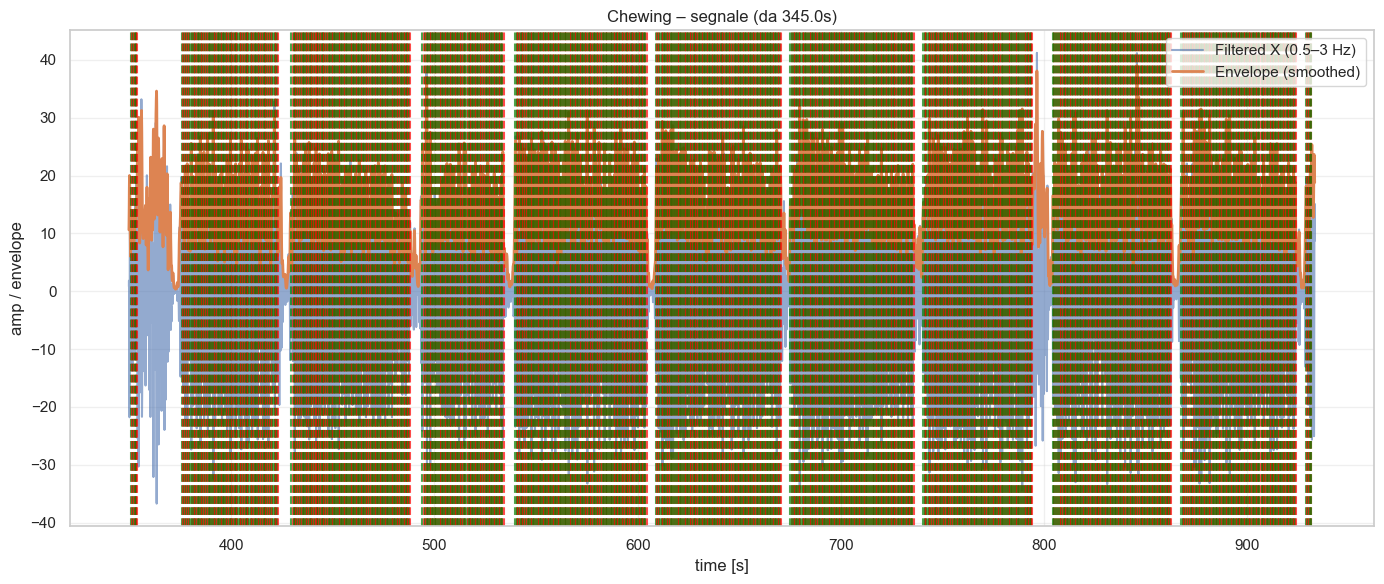

In [19]:
# ======================= CONFIG =======================
ACC_PATH   = r"C:\Users\eleut\OneDrive\Desktop\teraterm_11_08_2025_accelerometer.csv"
BORIS_PATH = r"C:\Users\eleut\OneDrive\Desktop\boris_video3.csv"

# Sync esplicito: video inizia 25 s prima di 374.75 s dell'accelerometro
OFFSET = 374.75 - 25.0      # = 349.75 s
SCALE  = 1.0                # nessuna dilatazione

# Parametri segnale
BANDPASS = (0.5, 3.0)       # Hz (banda chewing tipica)
ENV_SMOOTH_S = 0.30         # smoothing envelope [s]

# Definizione fasi
PHASE_GAP_S  = 2.5          # gap > 2.5 s tra chew => nuova fase
INTERPHASE_MAX_GAP_S = 10.0 # NON mostrare fasi isolate a >10 s dalla fase più vicina

# Plot
PHASE_VIEW_LEN_S   = 20.0   # mostra 20 s per ogni fase
PHASE_MARGIN_S     = 0.6
FINAL_START_S      = 345.0  # grafico finale parte da 345 s
FINAL_END_S        = None   # opzionale: es. 405.0 per fermarsi a 405 s
FIGSIZE_PHASE      = (12, 5)
FIGSIZE_FINAL      = (14, 6)
ALPHA_SIGNAL       = 0.6
# ======================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, hilbert

# -------------------- utility --------------------
def robust_seconds(s):
    """Converte in secondi; gestisce virgola decimale e timestamp ISO."""
    if getattr(s, "dtype", None) is not None and s.dtype.kind in "if":
        return s.astype(float)
    s_str = pd.Series(s).astype(str).str.replace(",", ".", regex=False).str.strip()
    sec = pd.to_numeric(s_str, errors="coerce")
    if sec.notna().any():
        return sec
    dt = pd.to_datetime(s_str, errors="coerce")
    return (dt - dt.iloc[0]).dt.total_seconds()

def butter_bandpass(low, high, fs, order=4):
    nyq = fs / 2.0
    lowc = max(1e-6, low/nyq)
    highc = min(0.999, high/nyq)
    b, a = butter(order, [lowc, highc], btype="band")
    return b, a

def plot_slice(t, x_filt, env_s, t0, t1, boris_sync, title="", show_events=True, figsize=(12,5)):
    m = (t >= t0) & (t <= t1)
    if not np.any(m):
        print(f"[plot_slice] Nessun dato tra {t0:.2f}–{t1:.2f}s")
        return
    plt.figure(figsize=figsize)
    plt.plot(t[m], x_filt[m], label="Filtered X (0.5–3 Hz)", alpha=ALPHA_SIGNAL)
    plt.plot(t[m], env_s[m], label="Envelope (smoothed)", linewidth=2)
    if show_events and boris_sync is not None and len(boris_sync):
        for _, r in boris_sync.iterrows():
            tt = r["t_acc_s"]
            if tt >= t0 and tt <= t1:
                col = "green" if r["Behavior"] == "S" else "red"
                plt.axvline(tt, color=col, linestyle="--", alpha=0.7)
    plt.title(title)
    plt.xlabel("time [s]"); plt.ylabel("amp / envelope")
    plt.legend(loc="upper right"); plt.grid(alpha=0.3); plt.tight_layout(); plt.show()

# -------------------- accelerometro --------------------
acc = pd.read_csv(ACC_PATH)
if "time_s" not in acc.columns or acc["time_s"].isna().all():
    if "timestamp" in acc.columns:
        ts = pd.to_datetime(acc["timestamp"], errors="coerce")
        acc["time_s"] = (ts - ts.iloc[0]).dt.total_seconds()
    else:
        raise ValueError("Serve 'time_s' o 'timestamp' nell'accelerometro.")

acc["time_s"] = robust_seconds(acc["time_s"])
for ax in ("x","y","z"):
    if ax not in acc.columns:
        raise ValueError(f"Manca la colonna '{ax}' nell'accelerometro.")

acc = acc.dropna(subset=["time_s","x","y","z"]).sort_values("time_s")
t = acc["time_s"].values
fs = 1.0 / np.median(np.diff(t))
print(f"fs ≈ {fs:.2f} Hz, N={len(t)}")

# asse laterale x (naso) -> filtro bandpass + envelope
b, a = butter_bandpass(BANDPASS[0], BANDPASS[1], fs, order=4)
x_raw = acc["x"].astype(float).values
x_filt = filtfilt(b, a, x_raw)
env = np.abs(hilbert(x_filt))
win = max(1, int(round(ENV_SMOOTH_S * fs)))
env_s = pd.Series(env).rolling(win, center=True, min_periods=1).mean().values

# -------------------- BORIS & sync --------------------
boris = pd.read_csv(BORIS_PATH)
bcol = "Behavior" if "Behavior" in boris.columns else next(c for c in boris.columns if "behav" in c.lower())
tcol = "Time"     if "Time"     in boris.columns else next(c for c in boris.columns if "time"  in c.lower())

beh = boris[bcol].astype(str).str.strip().str.upper()
tb  = robust_seconds(boris[tcol])

boris_sync = pd.DataFrame({"Behavior": beh, "t_boris_s": tb})
# mapping esplicito
boris_sync["t_acc_s"] = OFFSET + SCALE * boris_sync["t_boris_s"]
boris_sync = (boris_sync[boris_sync["Behavior"].isin(["S","E"])]
              .dropna(subset=["t_acc_s"])
              .sort_values("t_acc_s")
              .reset_index(drop=True))

# -------------------- chews (S->E) --------------------
chews = []
last_S = None
for _, r in boris_sync.iterrows():
    if r["Behavior"] == "S":
        last_S = float(r["t_acc_s"])
    elif r["Behavior"] == "E" and last_S is not None:
        tS, tE = last_S, float(r["t_acc_s"])
        if tE > tS:
            chews.append((tS, tE))
        last_S = None

chews = pd.DataFrame(chews, columns=["tS","tE"]).sort_values("tS").reset_index(drop=True)
if chews.empty:
    raise SystemExit("Nessun chew S→E dopo il sync (verifica Behavior/Time in BORIS).")

# timestamp caratteristico per segmentazione (inizio chew)
chews["tC"] = chews["tS"]

# -------------------- fasi: gap > 2.5 s tra chew --------------------
gaps = chews["tC"].diff().fillna(PHASE_GAP_S * 10)
phase_id = (gaps > PHASE_GAP_S).cumsum()
chews["phase_id"] = phase_id

phase_summary = (chews.groupby("phase_id")
                    .agg(n_chews=("tC","count"),
                         start=("tS","min"),
                         end=("tE","max"))
                    .reset_index())
phase_summary["duration_s"] = phase_summary["end"] - phase_summary["start"]

# distanza dalla fase precedente/successiva e fase più vicina
phase_summary = phase_summary.sort_values("start").reset_index(drop=True)
phase_summary["prev_gap"] = phase_summary["start"].diff().fillna(np.inf)
phase_summary["next_gap"] = (phase_summary["start"].shift(-1) - phase_summary["end"]).fillna(np.inf)
phase_summary["nearest_gap"] = phase_summary[["prev_gap","next_gap"]].min(axis=1)

# mostra SOLO fasi NON isolate (nearest_gap <= 10 s)
phases_to_plot = phase_summary[phase_summary["nearest_gap"] <= INTERPHASE_MAX_GAP_S].copy()

print(f"Fasi totali: {len(phase_summary)} | Mostrate (non isolate): {len(phases_to_plot)}")
# Salva opzionale
# phase_summary.to_csv("phase_summary.csv", index=False)

# -------------------- PLOT: zoom 20 s per ogni fase mostrata --------------------
for _, ph in phases_to_plot.iterrows():
    ph_len = ph["end"] - ph["start"]
    t0 = max(ph["start"] - PHASE_MARGIN_S, t[0])
    # se la fase è più lunga di 20 s, mostro i primi 20 s (con margine)
    if ph_len > PHASE_VIEW_LEN_S:
        t1 = min(ph["start"] + PHASE_VIEW_LEN_S + PHASE_MARGIN_S, t[-1])
        label = f"Fase {int(ph['phase_id'])} – primi {PHASE_VIEW_LEN_S:.1f}s (dur={ph_len:.2f}s)"
    else:
        t1 = min(ph["end"] + PHASE_MARGIN_S, t[-1])
        label = f"Fase {int(ph['phase_id'])} – completa (dur={ph_len:.2f}s)"
    plot_slice(t, x_filt, env_s, t0, t1, boris_sync, title=label, show_events=True, figsize=FIGSIZE_PHASE)

# -------------------- PLOT: finale (solo da 345 s) --------------------
end_s = float(t[-1]) if FINAL_END_S is None else float(FINAL_END_S)
plot_slice(t, x_filt, env_s, FINAL_START_S, end_s, boris_sync,
           title=f"Chewing – segnale (da {FINAL_START_S:.1f}s)", show_events=True, figsize=FIGSIZE_FINAL)
